# CS G520: Advanced Data Mining
# Lab Project

### Name: S Shashank
### ID: 2024PHXP2034H

# Chess Games Dataset

This notebook uses a dataset of 20,058 chess games with detailed metadata for each match. The dataset includes player information, match outcome, time control, number of turns, and opening strategies. It provides a rich base for game analysis, opening performance, player strength, and game termination insights.

## Dataset Overview: `games.csv`

| Column Name      | Description |
|------------------|-------------|
| `id`             | Unique identifier for each game |
| `rated`          | Boolean indicating whether the game was rated |
| `created_at`     | Timestamp (ms) when the game started |
| `last_move_at`   | Timestamp (ms) of the last move |
| `turns`          | Total number of half-moves (plies) played |
| `victory_status` | How the game ended (`mate`, `resign`, `timeout`, etc.) |
| `winner`         | Which player won the game (`white`, `black`, or `draw`) |
| `increment_code` | Time control format (e.g., `15+2` means 15 minutes base + 2s increment) |
| `white_id`       | Username of the white player |
| `white_rating`   | Elo rating of the white player |
| `black_id`       | Username of the black player |
| `black_rating`   | Elo rating of the black player |
| `moves`          | Full list of SAN-formatted moves played in the game |
| `opening_eco`    | ECO (Encyclopaedia of Chess Openings) code |
| `opening_name`   | Name of the chess opening |
| `opening_ply`    | Number of plies defining the opening line |

# Import Required Libraries


In [ ]:
# Install all required packages
!pip install pandas numpy seaborn matplotlib gradio scikit-learn networkx python-louvain tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 1.1 MB/s eta 0:00:00


In [ ]:
# Basic Libraries
import numpy as np
import pandas as pd
from collections import Counter
from tqdm import tqdm

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Machine Learning - Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# Machine Learning - Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

# Clustering - Evaluation Metrics
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)

# Machine Learning - Text Processing & Classification
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

# Community Detection
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from community import community_louvain

# UI
import gradio as gr

# Preprocessing and Exploratory Data Analysis

## Load the Dataset

In [ ]:
df = pd.read_csv("games.csv")

## Convert Timestamps to Datetime Format

In [ ]:
df['created_at'] = pd.to_datetime(df['created_at'], unit='ms')
df['last_move_at'] = pd.to_datetime(df['last_move_at'], unit='ms')

## Feature Engineering

In [ ]:
df['game_duration_sec'] = (df['last_move_at'] - df['created_at']).dt.total_seconds()
df['rating_diff'] = df['white_rating'] - df['black_rating']

## Drop Irrelevant Columns

In [ ]:
eda_df = df.drop(columns=['id', 'white_id', 'black_id', 'moves'])

## Clean Invalid Durations

In [ ]:
eda_df = eda_df[eda_df['game_duration_sec'].apply(lambda x: pd.notnull(x) and x > 0 and np.isfinite(x))]

## Set Seaborn Style

In [ ]:
sns.set(style='whitegrid')

## Preview Cleaned Data

In [ ]:
print(eda_df.head())

    rated          created_at        last_move_at  turns victory_status  \
14  False 2017-08-30 10:46:40 2017-08-30 13:33:20     31           mate   
43  False 2017-07-09 14:20:00 2017-07-09 17:06:40     66         resign   
49  False 2017-06-25 14:13:20 2017-06-25 17:00:00     41           mate   
52  False 2017-06-19 16:33:20 2017-06-19 19:20:00     53           mate   
54   True 2017-08-20 09:06:40 2017-08-20 11:53:20      8         resign   

   winner increment_code  white_rating  black_rating opening_eco  \
14  white          15+15          1094          1141         C50   
43  white          40+40          2443           978         B76   
49  white          40+40          2436           978         B01   
52  white           10+0           978          1500         A80   
54  white           16+0          1521          1162         A04   

                                         opening_name  opening_ply  \
14               Four Knights Game: Italian Variation            8   


## Victory Status Distribution

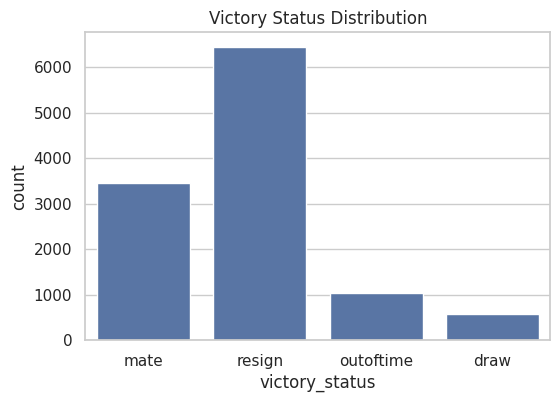

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='victory_status', data=eda_df)
plt.title("Victory Status Distribution")
plt.show()

## Winner Distribution

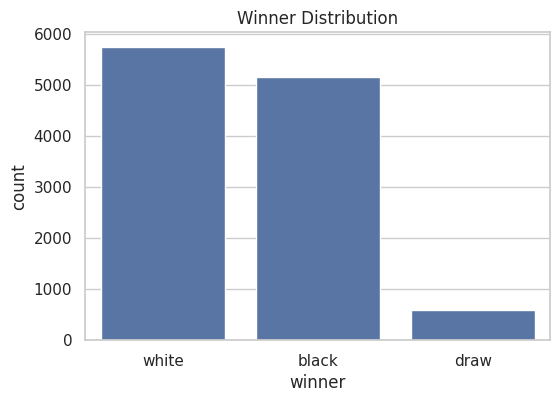

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='winner', data=eda_df)
plt.title("Winner Distribution")
plt.show()

## Game Duration Distribution

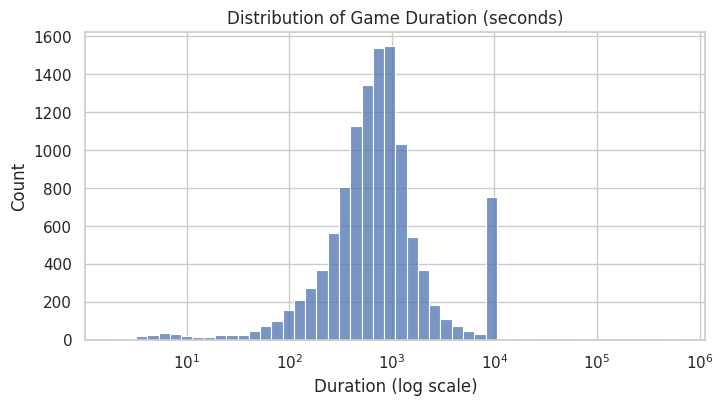

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(eda_df['game_duration_sec'], bins=50, log_scale=True)
plt.title("Distribution of Game Duration (seconds)")
plt.xlabel("Duration (log scale)")
plt.show()

## Rating Difference vs Winner

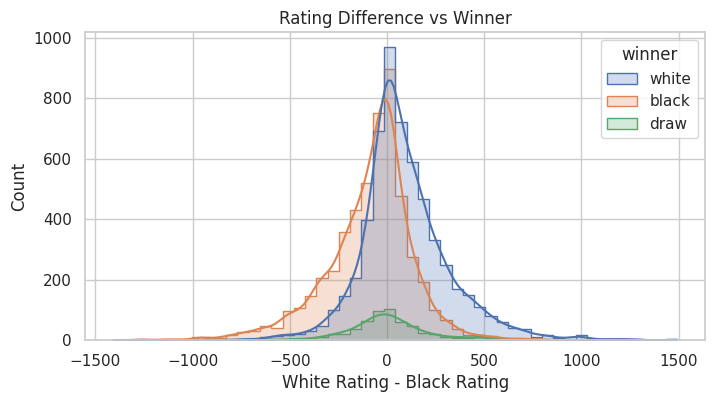

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(data=eda_df, x='rating_diff', hue='winner', bins=50, kde=True, element='step')
plt.title("Rating Difference vs Winner")
plt.xlabel("White Rating - Black Rating")
plt.show()

## Top 10 Most Common Openings

<ipython-input-14-ab2f647ca2f8>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_openings.values, y=top_openings.index, palette='viridis')


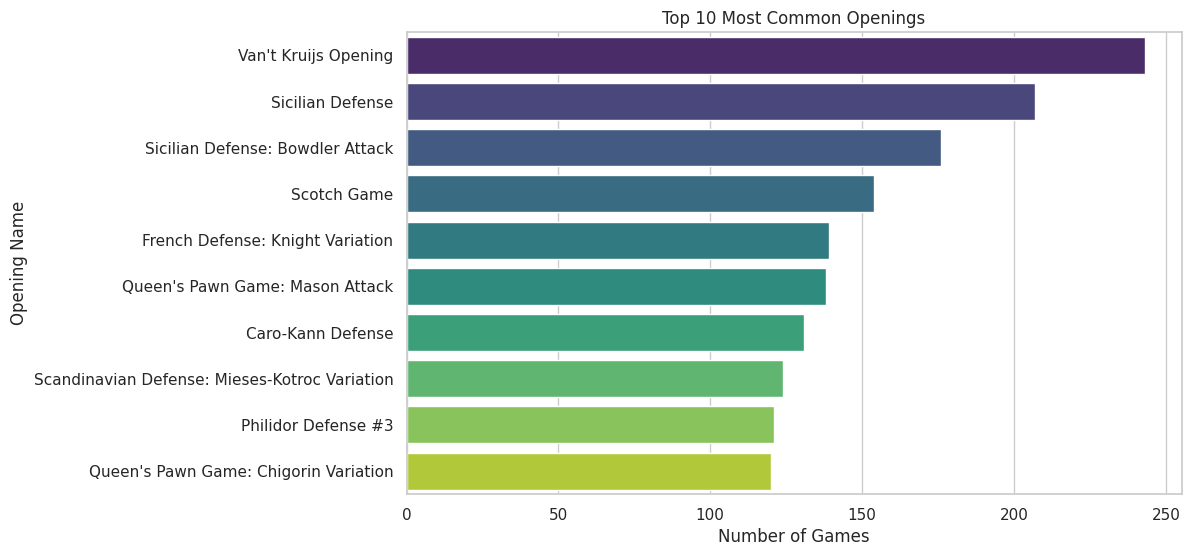

In [ ]:
top_openings = eda_df['opening_name'].value_counts().nlargest(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_openings.values, y=top_openings.index, palette='viridis')
plt.title("Top 10 Most Common Openings")
plt.xlabel("Number of Games")
plt.ylabel("Opening Name")
plt.show()

# Clustering Algorithms

## Feature Selection

In [ ]:
features = eda_df[[
    'turns',
    'game_duration_sec',
    'rating_diff',
    'opening_ply'
]].copy()

## One-Hot Encode Categorical Features

In [ ]:
encoded = pd.get_dummies(eda_df[['victory_status', 'winner']], drop_first=True)
features = pd.concat([features, encoded], axis=1)

## Feature Standardization


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

## PCA for 2D Visualization


In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

## Define Clustering Algorithms


In [ ]:
algorithms = {
    'KMeans': KMeans(n_clusters=4, random_state=42, n_init=10),
    'Agglomerative': AgglomerativeClustering(n_clusters=4),
    'GMM': GaussianMixture(n_components=4, random_state=42),
    'DBSCAN': DBSCAN(eps=1.2, min_samples=10)
}

## Fit, Predict, Evaluate, and Visualize


<ipython-input-20-34beef6c710c>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(None, len(unique_labels))
<ipython-input-20-34beef6c710c>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(None, len(unique_labels))
<ipython-input-20-34beef6c710c>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(None, len(unique_labels))
<ipython-input-20-34beef6c710c>:23: MatplotlibDeprecationWarning: The get_cmap functi

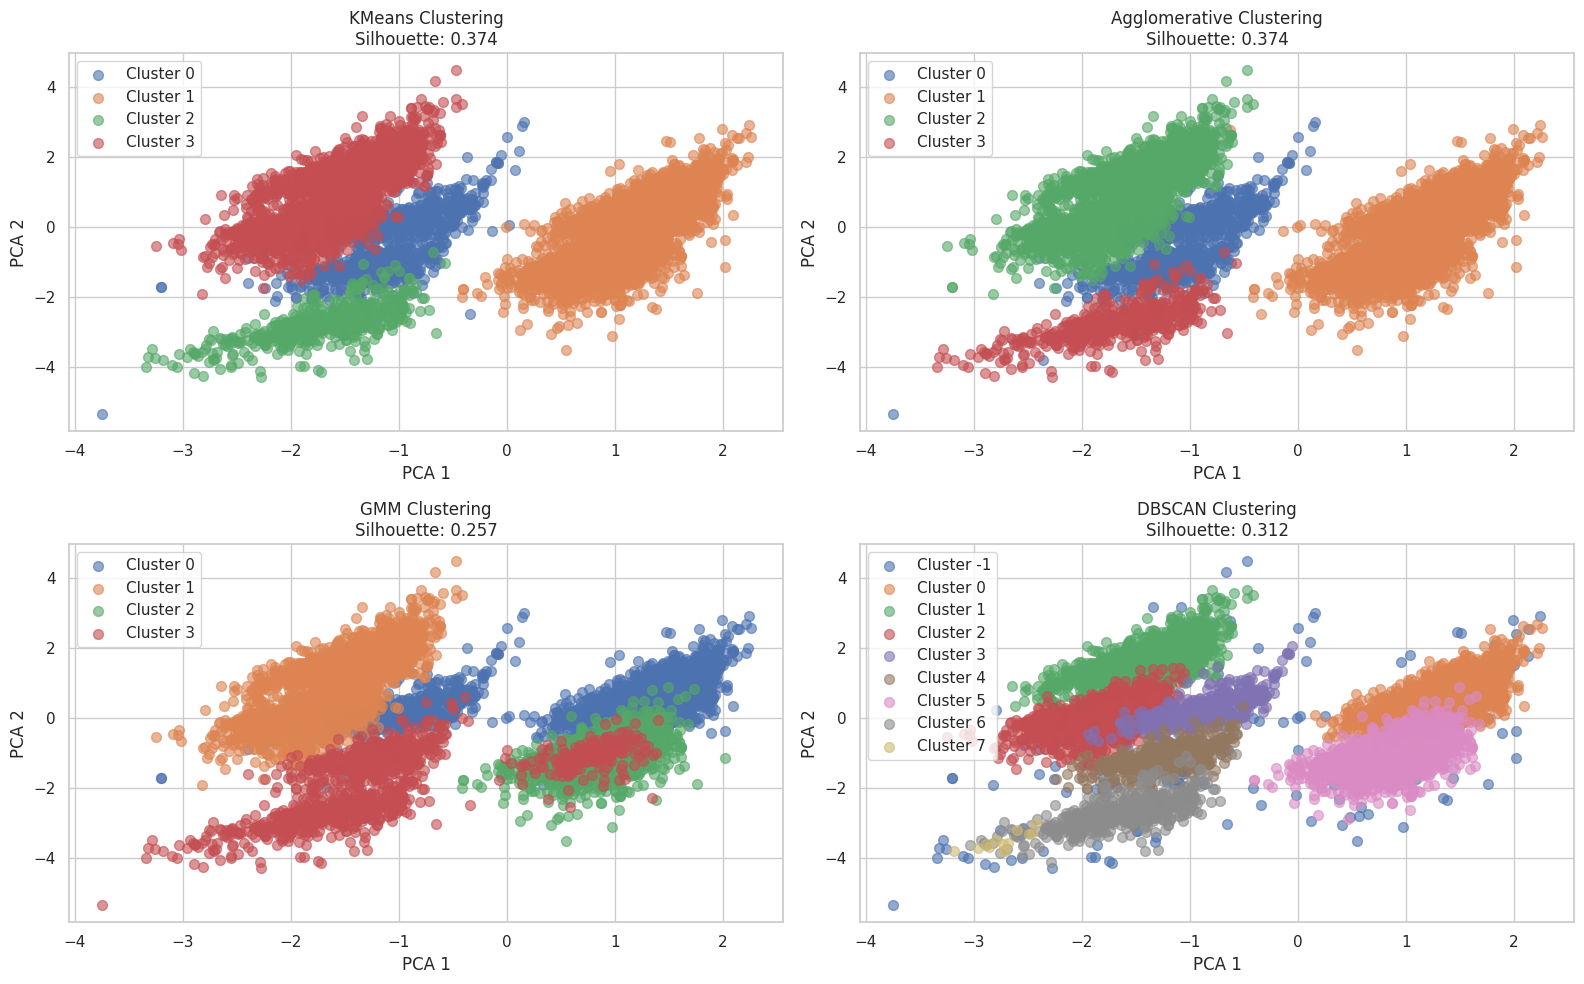

In [ ]:
results = []
plt.figure(figsize=(16, 10))
for i, (name, model) in enumerate(algorithms.items(), 1):

    labels = model.fit_predict(X_scaled)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    sil = silhouette_score(X_scaled, labels) if n_clusters > 1 else -1
    ch = calinski_harabasz_score(X_scaled, labels) if n_clusters > 1 else -1
    db = davies_bouldin_score(X_scaled, labels) if n_clusters > 1 else -1

    results.append({
        'Model': name,
        'Silhouette Score': sil,
        'Calinski-Harabasz': ch,
        'Davies-Bouldin': db,
        'n_clusters': n_clusters
    })

    plt.subplot(2, 2, i)
    unique_labels = sorted(set(labels))
    cmap = cm.get_cmap(None, len(unique_labels))
    for j, lbl in enumerate(unique_labels):
        idx = labels == lbl
        plt.scatter(X_pca[idx, 0], X_pca[idx, 1], s=50, label=f'Cluster {lbl}', alpha=0.6)
    plt.title(f"{name} Clustering\nSilhouette: {sil:.3f}")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend()

plt.tight_layout()
plt.show()

## Comparative Metrics Table


In [ ]:
results_df = pd.DataFrame(results)
print("Comparative Clustering Metrics:\n", results_df)

Comparative Clustering Metrics:
            Model  Silhouette Score  Calinski-Harabasz  Davies-Bouldin  \
0         KMeans          0.374162        3220.173880        1.051416   
1  Agglomerative          0.374113        3205.571515        1.051657   
2            GMM          0.257004        2191.716110        1.573300   
3         DBSCAN          0.311596        1891.837164        1.975540   

   n_clusters  
0           4  
1           4  
2           4  
3           8  


## Visual Summary of Metrics


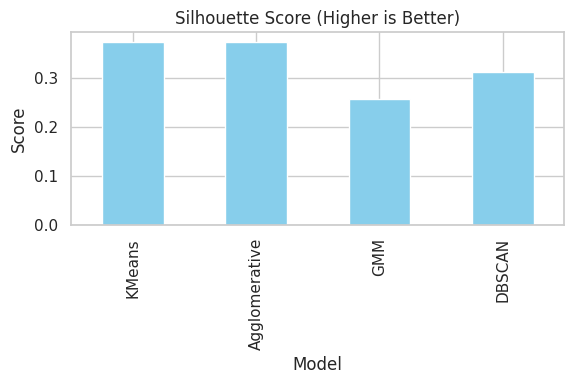

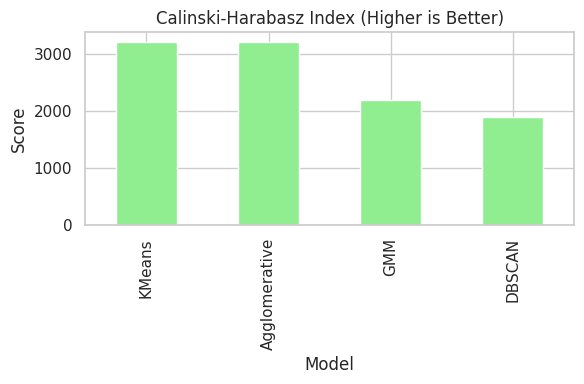

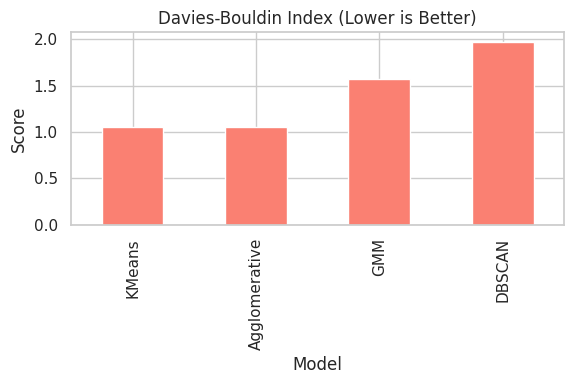

In [ ]:
import matplotlib.pyplot as plt

metrics_df = results_df.set_index("Model")

plt.figure(figsize=(6, 4))
metrics_df['Silhouette Score'].plot(kind='bar', color='skyblue')
plt.title('Silhouette Score (Higher is Better)')
plt.ylabel("Score")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
metrics_df['Calinski-Harabasz'].plot(kind='bar', color='lightgreen')
plt.title('Calinski-Harabasz Index (Higher is Better)')
plt.ylabel("Score")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
metrics_df['Davies-Bouldin'].plot(kind='bar', color='salmon')
plt.title('Davies-Bouldin Index (Lower is Better)')
plt.ylabel("Score")
plt.tight_layout()
plt.show()

# Community Detection

## Build Player Profiles


In [ ]:
def extract_player_profiles(df):
    white_df = df[['white_id', 'white_rating', 'opening_name']].rename(
        columns={'white_id': 'player_id', 'white_rating': 'rating', 'opening_name': 'opening'})
    black_df = df[['black_id', 'black_rating', 'opening_name']].rename(
        columns={'black_id': 'player_id', 'black_rating': 'rating', 'opening_name': 'opening'})
    combined = pd.concat([white_df, black_df])

    sampled_players = combined['player_id'].drop_duplicates().sample(n=3000, random_state=42)
    combined = combined[combined['player_id'].isin(sampled_players)]

    opening_mode = combined.groupby('player_id')['opening'].agg(lambda x: Counter(x).most_common(1)[0][0])
    rating_mean = combined.groupby('player_id')['rating'].mean()

    profiles = pd.DataFrame({
        'avg_rating': rating_mean,
        'fav_opening': opening_mode
    })
    return profiles

player_profiles = extract_player_profiles(df)

opening_encoder = LabelEncoder()
player_profiles['opening_code'] = opening_encoder.fit_transform(player_profiles['fav_opening'])

## Construct Similarity Graph


In [ ]:
scaler = StandardScaler()
features = scaler.fit_transform(player_profiles[['avg_rating', 'opening_code']])

similarity_matrix = cosine_similarity(features)

G = nx.Graph()
players = player_profiles.index.tolist()

for i, player in tqdm(enumerate(players), total=len(players)):
    G.add_node(player)
    sim_scores = list(enumerate(similarity_matrix[i]))
    sim_scores = sorted(sim_scores, key=lambda x: -x[1])[1:11]  # Top 10 (excluding self)
    for j, sim in sim_scores:
        G.add_edge(player, players[j], weight=sim)

100%|██████████| 3000/3000 [00:06<00:00, 485.51it/s]


## Louvain Community Detection


In [ ]:
partition = community_louvain.best_partition(G, weight='weight')

df_partition = pd.DataFrame.from_dict(partition, orient='index', columns=['community'])
player_profiles = player_profiles.join(df_partition)

## Visualize Top Communities


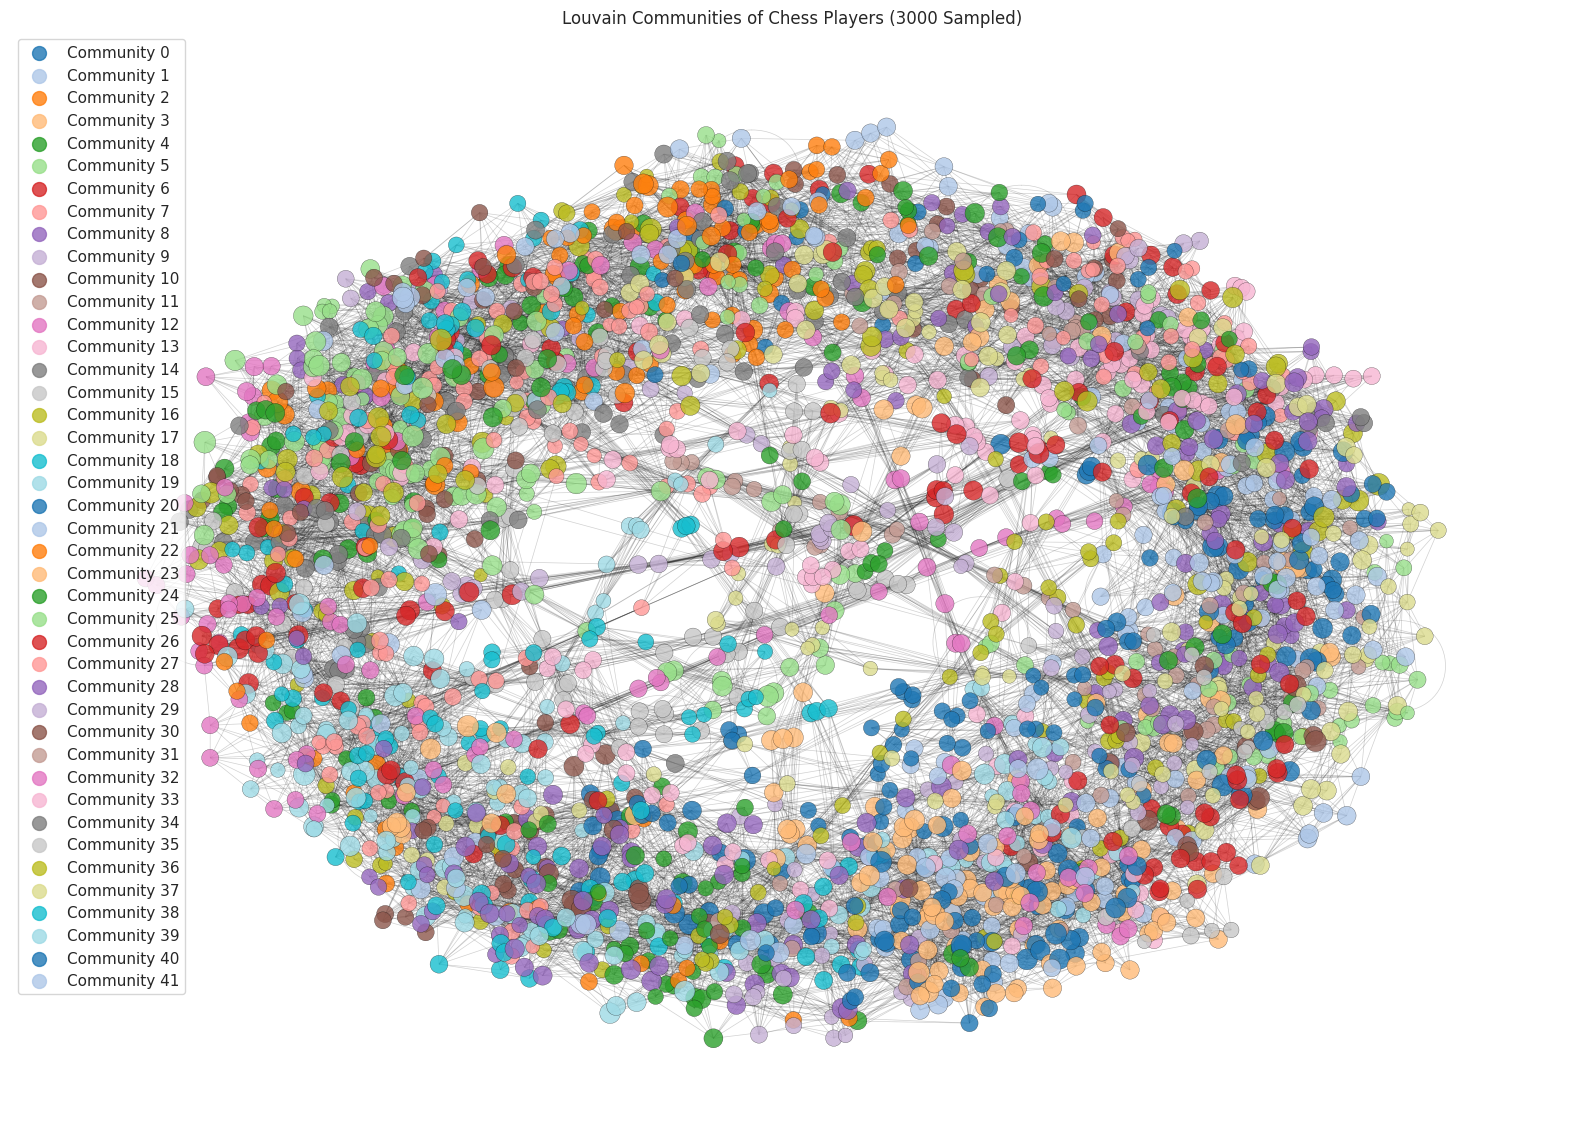

In [ ]:
community_sizes = player_profiles['community'].value_counts()
top_communities = community_sizes[community_sizes > 10].index.tolist()

subgraph_nodes = [n for n in G.nodes if partition[n] in top_communities]
G_sub = G.subgraph(subgraph_nodes)

unique_communities = sorted(set(partition[n] for n in G_sub.nodes()))
palette = sns.color_palette("tab20", n_colors=len(unique_communities))
community_color_map = {comm: palette[i] for i, comm in enumerate(unique_communities)}

node_colors = [community_color_map[partition[node]] for node in G_sub.nodes()]

node_sizes = [player_profiles.loc[node]['avg_rating'] / 10 for node in G_sub.nodes()]

pos = nx.spring_layout(G_sub, seed=42, k=0.15)  # k controls the spacing

plt.figure(figsize=(16, 12))
nx.draw_networkx_nodes(G_sub, pos,
                       node_color=node_colors,
                       node_size=node_sizes,
                       alpha=0.8,
                       linewidths=0.2,
                       edgecolors='black')
nx.draw_networkx_edges(G_sub, pos, alpha=0.2, width=0.5)

for comm in unique_communities:
    plt.scatter([], [], c=[community_color_map[comm]], alpha=0.8, s=100,
                label=f'Community {comm}')

plt.legend(scatterpoints=1, frameon=True, labelspacing=0.5, loc='best')
plt.title("Louvain Communities of Chess Players (3000 Sampled)")
plt.axis('off')
plt.tight_layout()
plt.show()

## Sample Players from Each Community

In [ ]:
for c in top_communities:
    members = player_profiles[player_profiles['community'] == c]
    print(f"Community {c}: {len(members)} members")
    print("  Avg ELO:", round(members['avg_rating'].mean(), 2))
    print("  Top Openings:", members['fav_opening'].value_counts().head(3).to_dict())
    print()

Community 16: 98 members
  Avg ELO: 1294.2
  Top Openings: {"King's Pawn Game: Wayward Queen Attack": 12, "King's Knight Opening: Normal Variation": 10, "King's Pawn Game: Leonardis Variation": 10}

Community 8: 95 members
  Avg ELO: 1835.06
  Top Openings: {'French Defense: Knight Variation': 6, 'Indian Game': 4, 'Hungarian Opening': 3}

Community 28: 93 members
  Avg ELO: 1427.39
  Top Openings: {'French Defense: Knight Variation': 6, 'Four Knights Game: Italian Variation': 3, 'Elephant Gambit': 3}

Community 17: 93 members
  Avg ELO: 1233.35
  Top Openings: {'Modern Defense': 12, "King's Pawn Game: Wayward Queen Attack": 9, "King's Pawn Game: Damiano Defense": 7}

Community 20: 92 members
  Avg ELO: 1987.33
  Top Openings: {'Modern Defense': 6, "King's Pawn Game: Leonardis Variation": 5, 'Horwitz Defense': 5}

Community 2: 91 members
  Avg ELO: 1455.88
  Top Openings: {"Van't Kruijs Opening": 6, 'Scotch Game': 5, 'Sicilian Defense: Old Sicilian': 4}

Community 5: 90 members
  Avg EL

# Classification & Prediction

## Data Loading and Preparation

In [ ]:
df_games = pd.read_csv('games.csv')
df_games = df_games.dropna(subset=['moves', 'winner'])
df_games = df_games[df_games['winner'].isin(['white', 'black'])]
df_games = df_games.sample(frac=0.1, random_state=42)

vectorizer = CountVectorizer(max_features=1000, tokenizer=lambda x: x.split())
X = vectorizer.fit_transform(df_games['moves'])
y = df_games['winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## Multinomial Naive Bayes

Accuracy: 0.7076
              precision    recall  f1-score   support

       black       0.68      0.70      0.69       176
       white       0.74      0.71      0.73       207

    accuracy                           0.71       383
   macro avg       0.71      0.71      0.71       383
weighted avg       0.71      0.71      0.71       383



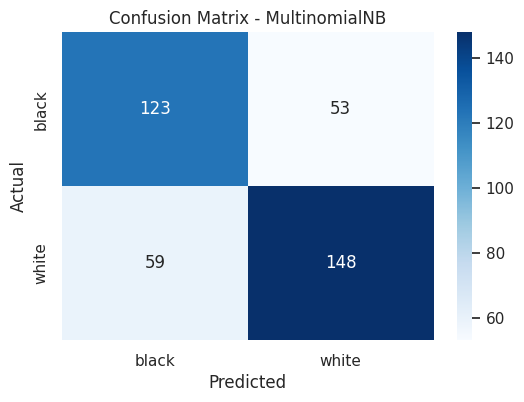

In [ ]:
model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - MultinomialNB")
plt.show()


## Decision Tree


Decision Tree Accuracy: 0.5483
              precision    recall  f1-score   support

       black       0.51      0.45      0.48       176
       white       0.57      0.63      0.60       207

    accuracy                           0.55       383
   macro avg       0.54      0.54      0.54       383
weighted avg       0.54      0.55      0.54       383



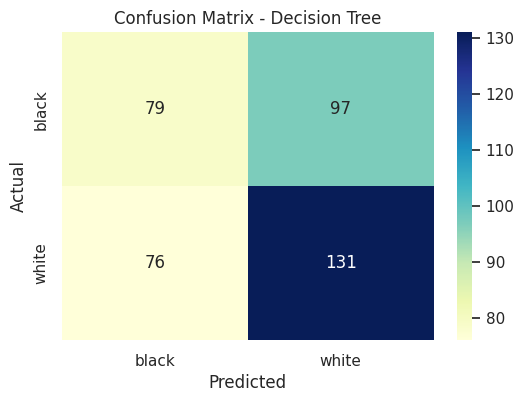

In [ ]:
clf = DecisionTreeClassifier(max_depth=20, min_samples_split=10, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(f"\nDecision Tree Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

## Logistic Regression


Logistic Regression Accuracy: 0.6632
              precision    recall  f1-score   support

       black       0.62      0.68      0.65       176
       white       0.70      0.65      0.68       207

    accuracy                           0.66       383
   macro avg       0.66      0.66      0.66       383
weighted avg       0.67      0.66      0.66       383



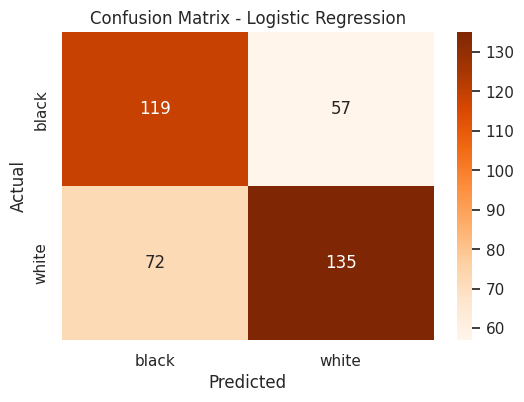

In [ ]:
clf = LogisticRegression(max_iter=200)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(f"\nLogistic Regression Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

## Next Move Predictor (Majority Voting)

In [ ]:
move_counts = Counter(" ".join(df_games['moves']).split())
candidate_moves = [move for move, _ in move_counts.most_common(20)]
clf_lr = clf

def predict_next_move(user_input_moves):
    move_list = user_input_moves.strip().split()
    turn = 'white' if len(move_list) % 2 == 0 else 'black'

    scores = {'MultinomialNB': {}, 'DecisionTree': {}, 'LogisticRegression': {}}
    best_moves = {}
    move_probs = {}

    idx_target = list(model.classes_).index(turn)

    for move in candidate_moves:
        test_sequence = f"{user_input_moves} {move}".strip()
        X_test_seq = vectorizer.transform([test_sequence])

        nb_proba = model.predict_proba(X_test_seq)[0][idx_target]
        tree_proba = clf.predict_proba(X_test_seq)[0][idx_target]
        lr_proba = clf_lr.predict_proba(X_test_seq)[0][idx_target]

        scores['MultinomialNB'][move] = nb_proba
        scores['DecisionTree'][move] = tree_proba
        scores['LogisticRegression'][move] = lr_proba

    for model_name in scores:
        best_move = max(scores[model_name], key=scores[model_name].get)
        best_moves[model_name] = best_move

    move_votes = list(best_moves.values())
    vote_counter = Counter(move_votes)
    final_move, _ = vote_counter.most_common(1)[0]

    contributing_probs = [
        scores[model_name][final_move]
        for model_name, move in best_moves.items()
        if move == final_move
    ]
    avg_prob = sum(contributing_probs) / len(contributing_probs)

    return f"Recommended Move: {final_move}", f"Confidence (Avg. P({turn} wins)): {avg_prob:.4f}"

# Gradio Interface
gr.Interface(
    fn=predict_next_move,
    inputs=gr.Textbox(lines=2, placeholder="e.g., e4 e5 Nf3 Nc6", label="Enter current move sequence"),
    outputs=[
        gr.Textbox(label="Recommended Move"),
        gr.Textbox(label="Confidence")
    ],
    title="Chess Move Predictor",
    description="Predict the best next chess move using a majority vote of three classifiers."
).launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1cb4ade9f670de786a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
